# Machine Learning for the Sensored Internet of Things

## Who am I
Hank Roark
Data Scientist & Hacker @ H2O.ai

Lecturer in Systems Thinking, University of Illinois at Urbana-Champaign

John Deere, Research, Software Product Development, High Tech Ventures

Lots of time dealing with data off of machines, equipment, satellites, radar, hand sampled, and on.

Geospatial and temporal / time series data almost all from sensors.

Previously at startups and consulting (Red Sky Interactive, Nuforia, NetExplorer, Perot Systems, a few of my own)

Systems Design & Management MIT<br>
Physics Georgia Tech

hroark@alum.mit.edu<br>
@hankroark<br>
https://www.linkedin.com/in/hankroark

## IoT Data Comes From Lots of Places, much of it from sensors

<img src="https://gkapteina.files.wordpress.com/2015/08/br-internet-of-things-ecosystem.jpg">

## The data is going to be huge, so get ready
<img src="http://www8.hp.com/h30458/media2.php/EZINE/April%20infographics/APR_IM_INFOG.jpg?version=349e115e815fac03bd19756911efee13">

## Wow, how big is a brontobyte?
<img src="http://www.intellaegis.com/wp-content/uploads/2015/01/IOT-Explosion.jpg">

## Nah, will the data really be that big?

In [ ]:
#from IPython.display import IFrame
#IFrame('http://www.vrworld.com/2015/05/08/big-data-in-planes-new-pw-gtf-engine-telemetry-to-generate-10gbs/', width=800, height=350)

# This much data will require a fast OODA loop
## Much of these models will then be used in control systems
<img src="http://www.telecom-cloud.net/wp-content/uploads/2015/05/Screen-Shot-2015-05-27-at-3.51.47-PM.png" width=800>

# Use Case on Simulated Sensor Data


## Prognostics
Prognostics is an engineering discipline focused on predicting the time at which a system or a component will no longer perform its intended function.  This lack of performance is most often a failure beyond which the system can no longer be used to meet desired performance. The predicted time then becomes the remaining useful life (RUL), which is an important concept in decision making for contingency mitigation.

https://en.wikipedia.org/wiki/Prognostics


## Machine Learning Prognostics for Turbofan Engine Degradation Dataset

Information about the problem is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan and original data is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

The data was originally generated using the Commercial Modular Aero-Propulsion System Simulations (C-MAPPS) system.

The approach used in the turbofan engine degradation dataset was then used in the PHM08 challenge.  Information about other research on the C-MAPSS data is available at  https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2014/phmc_14_063.pdf


## Sometimes the simple things work
"A significant characteristic of the PHM Challenge dataset is that it contains time series and therefore the representation of time or at least how to represent and take account of previous temporal observations is an important consideration. The <b>quickest and
simplest method for representing time is to consider each time
point independently and create a prediction at each time step</b>.
An alternative representation would be to consider using a
phase space embedding representation, in which a sequence of
instances is generated using a fixed length sliding window.
However <b>phase space embedding has the significant drawback
of increasing the number of dimensions proportionally with
each time step represented, giving rise to the problems
associated with the 'curse of dimensionality'</b>. From preliminary
experiments it was found that the prediction performance did
not improve significantly using the embedding space
representation given the increase in computational demands.
Therefore the chosen representation was to predict remaining
life using single time points".

Leto Peel, Member, IEEE (GOLD) " Data Driven Prognostics using a
Kalman Filter Ensemble of Neural Network Models" 2008
international conference on prognostics and health management.

## The approach of treating each time point independently will be used

In [27]:
# some ML
import h2o

# some munging, pre- and post-processing
import numpy as np
import pandas as pd
import pykalman as pyk

# some exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Doing hyper parameter searches only when needed
do_grid_search = False

# Preprocessing

In [2]:
# Input files don't have column names
dependent_var = ['RemainingUsefulLife']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

### Read in the raw files

In [3]:
h2o.init()



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/s0/p0vdydrd5jl4n0cg5w3v6nrh0000gn/T/tmppEti_9/h2o_hank_started_from_python.out
JVM stderr: /var/folders/s0/p0vdydrd5jl4n0cg5w3v6nrh0000gn/T/tmpxTGNDL/h2o_hank_started_from_python.err
Using ice_root: /var/folders/s0/p0vdydrd5jl4n0cg5w3v6nrh0000gn/T/tmpLj2RTt


Java Version: java version "1.8.0_60"
Java(TM) SE Runtime Environment (build 1.8.0_60-b27)
Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)


Starting H2O JVM and connecting: ............... Connection successful!


H2O cluster uptime:,1 seconds 372 milliseconds
H2O cluster version:,3.6.0.8
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,5.33 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [4]:
train = h2o.upload_file("../CMAPSSData/train_FD001.txt")
test  = h2o.upload_file("../CMAPSSData/test_FD001.txt")
train.set_names(input_file_column_names);
test.set_names(input_file_column_names);


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


In [5]:
train[train['UnitNumber'] == 1].head(5)


UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
1,1,-0.0007,-0.0004,100,518.67,641.82,1589.7,1400.6,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.419
1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39,23.4236
1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.2,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
1,4,0.0007,0,100,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,21.61,554,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.8,8.4294,0.03,393,2388,100,38.9,23.4044


In [6]:
train[train['UnitNumber'] == 1].tail(5)

UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
1,188,-0.0067,0.0003,100,518.67,643.75,1602.38,1422.78,14.62,21.61,551.94,2388.31,9037.91,1.3,48,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100,38.51,22.9588
1,189,-0.0006,0.0002,100,518.67,644.18,1596.17,1428.01,14.62,21.61,550.7,2388.27,9044.55,1.3,48.08,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100,38.48,23.1127
1,190,-0.0027,0.0001,100,518.67,643.64,1599.22,1425.95,14.62,21.61,551.29,2388.29,9040.58,1.3,48.33,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100,38.49,23.0675
1,191,0,-0.0004,100,518.67,643.34,1602.36,1425.77,14.62,21.61,550.92,2388.28,9042.76,1.3,48.15,519.57,2388.3,8114.61,8.5174,0.03,394,2388,100,38.45,23.1295
1,192,0.0009,0,100,518.67,643.54,1601.41,1427.2,14.62,21.61,551.25,2388.32,9033.22,1.3,48.25,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100,38.48,22.9649


### Calculate Remaining Useful Life in T-minus notation for the training data
This puts all data on the same basis for supervised training

In [7]:
def add_remaining_useful_life(h2o_frame):
    # Get the total number of cycles for each unit
    grouped_by_unit = h2o_frame.group_by(by=["UnitNumber"])
    max_cycle = grouped_by_unit.max(col="Cycle").get_frame()
    
    # Merge the max cycle back into the original frame
    result_frame = h2o_frame.merge(max_cycle)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_Cycle"] - result_frame["Cycle"]
    result_frame["RemainingUsefulLife"] = remaining_useful_life
    
    # drop the un-needed column
    result_frame = result_frame.drop("max_Cycle")
    return result_frame

train_with_predictor = add_remaining_useful_life(train)

In [8]:
train_with_predictor[train_with_predictor['UnitNumber'] == 1].head(5)

UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,RemainingUsefulLife
1,1,-0.0007,-0.0004,100,518.67,641.82,1589.7,1400.6,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.419,191
1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39,23.4236,190
1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.2,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,189
1,4,0.0007,0,100,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,188
1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,21.61,554,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.8,8.4294,0.03,393,2388,100,38.9,23.4044,187


## Exploratory Data Analysis

Look at how the sensor measures evolve over time (first column) as well as how they relate to each other for a subset of the units.


In [11]:
train_pd = train_with_predictor.as_data_frame(use_pandas=True)

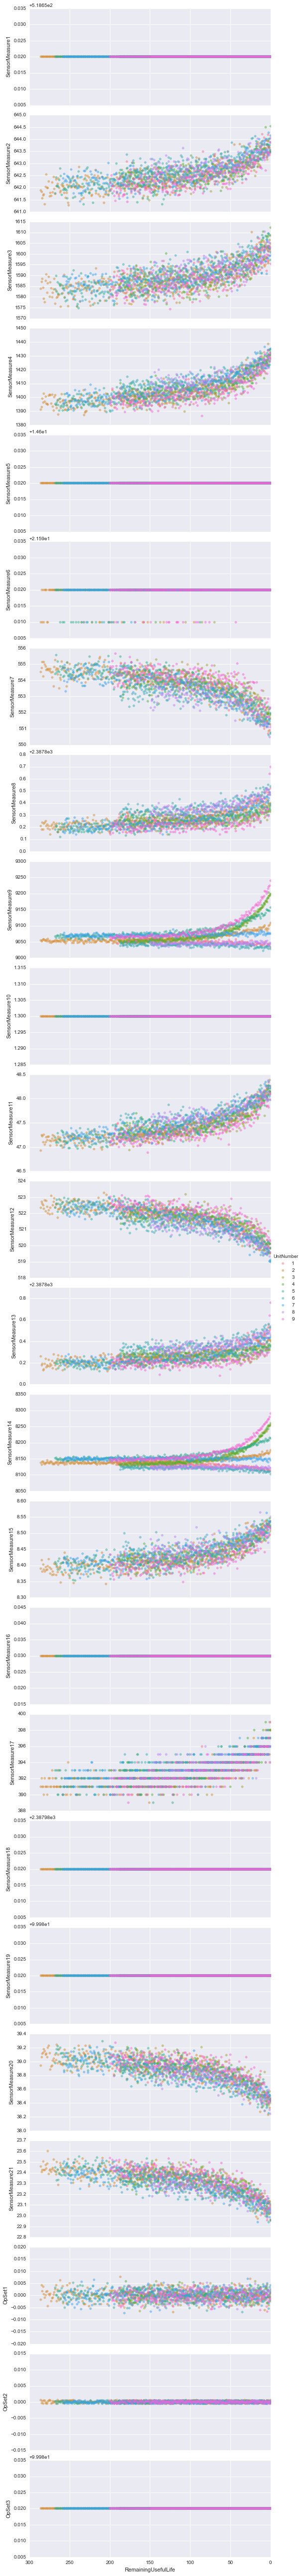

In [18]:
g = sns.PairGrid(data=train_pd.query('UnitNumber < 10') ,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_columns_names + operational_settings_columns_names,
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.scatter, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

Confirms that the operational settings are within one small operational region.

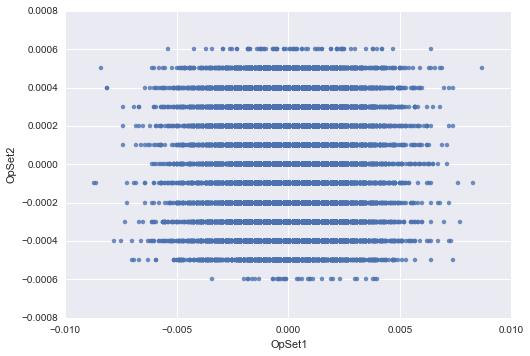

In [19]:
g = sns.regplot(data=train_pd, x="OpSet1", y="OpSet2", fit_reg=False)

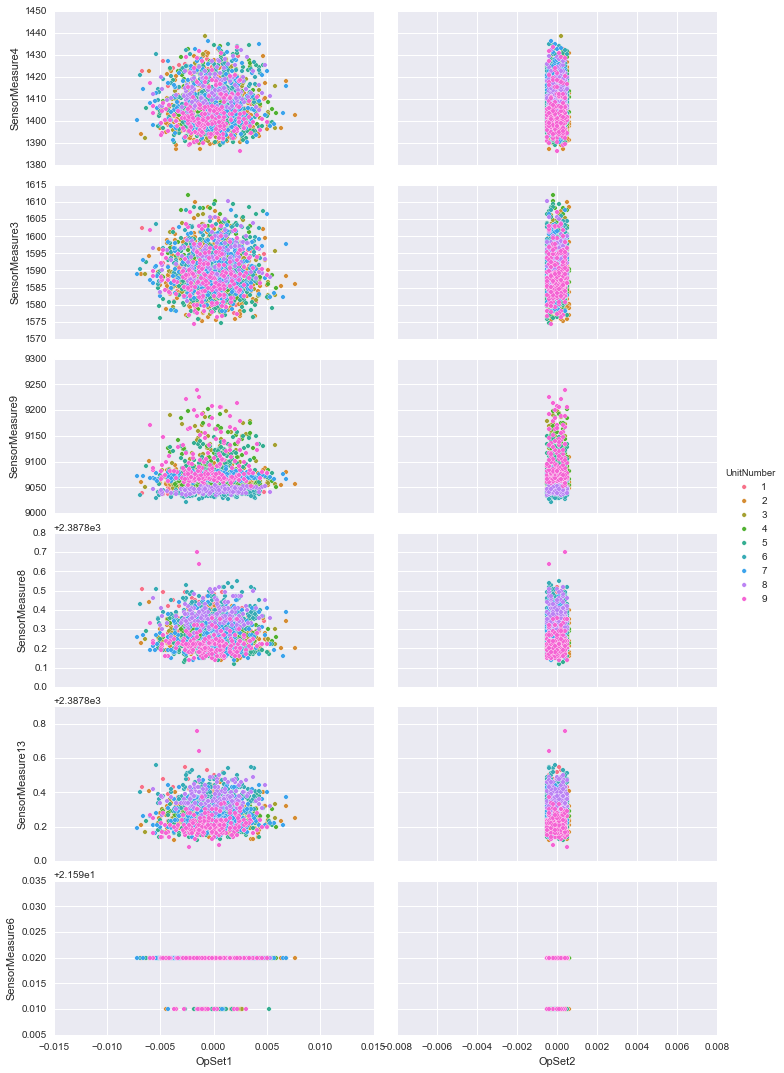

In [20]:
g = sns.pairplot(data=train_pd.query('UnitNumber < 10'),
                 x_vars=["OpSet1","OpSet2"],
                 y_vars=["SensorMeasure4", "SensorMeasure3", "SensorMeasure9", "SensorMeasure8", "SensorMeasure13", "SensorMeasure6"],
                 hue="UnitNumber", aspect=2)


## Feature Selection

These features were selected partially after looking at the graphs above...

But partially because later on thin the ML work certain features produced more predictive models (e.g., including Sensor 6 improved cross validation results) and some things improve results when being dropped (Operational Settings).

In [21]:
independent_vars = ["SensorMeasure"+str(i) for i in [2,3,4,6,7,8,9,11,12,13,14,15,17,20,21]]

# Modeling

### Setup cross validation
Setup a fold column to great cross validation models from 90 units and cross validating on 10 units.  This creates a 10-fold cross validation.  The cross validation models are then used to create an ensemble model for predictions

In [25]:
fold_col = "UnitNumberMod10"
train_with_predictor[fold_col] = train_with_predictor["UnitNumber"] % 10

### Train a series of GLM Models using Grid Search over $\alpha$ and $\lambda$
I like GLMs, they are fast.  But don't deal well with non-linearity.

In [36]:
h2o.no_progress()
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [45]:
do_grid_search=True
def train_glm(x_cols, y_col, training_frame, fold_col, alpha=0.5, regularization=1e-5, family="gaussian"):
    print "Building GLM, alpha="+str(alpha)+", lamba="+str(regularization)+", family="+family
    estimator = H2OGeneralizedLinearEstimator(family=family, alpha=alpha, Lambda=regularization, 
                                              keep_cross_validation_predictions=True)
    estimator.train(x=x_cols, y=y_col, training_frame=training_frame, fold_column=fold_col)
    return estimator

def grid_search_glm(x_cols, y_col, training_frame, fold_col, 
                    alphas = [0,0.5,1], regularizations=np.logspace(-4,0,num=5),
                    families = ["gaussian", "poisson"]):
    print "Beginning GLM hyperparameter search"
    results = [train_glm(x_cols, y_col, training_frame, fold_col, alpha, regularization, family) 
               for alpha in alphas
               for regularization in regularizations
               for family in families ]
    print "Finished GLM hyperparameter search"
    return results

if do_grid_search:
    glm_models = grid_search_glm(independent_vars,dependent_var,
                                 training_frame=train_with_predictor,fold_col=fold_col)
else:
    # this is used to speed up the demonstration by just building the single model previously found
    glm_models = [train_glm(independent_vars,dependent_var,
                            training_frame=train_with_predictor,fold_col=fold_col,
                            alpha=0.,regularization=0.01, family="gaussian" )]

Beginning GLM hyperparameter search
Building GLM, alpha=0, lamba=0.0001, family=gaussian
Building GLM, alpha=0, lamba=0.0001, family=poisson
Building GLM, alpha=0, lamba=0.001, family=gaussian
Building GLM, alpha=0, lamba=0.001, family=poisson
Building GLM, alpha=0, lamba=0.01, family=gaussian
Building GLM, alpha=0, lamba=0.01, family=poisson
Building GLM, alpha=0, lamba=0.1, family=gaussian
Building GLM, alpha=0, lamba=0.1, family=poisson
Building GLM, alpha=0, lamba=1.0, family=gaussian
Building GLM, alpha=0, lamba=1.0, family=poisson
Building GLM, alpha=0.5, lamba=0.0001, family=gaussian
Building GLM, alpha=0.5, lamba=0.0001, family=poisson
Building GLM, alpha=0.5, lamba=0.001, family=gaussian
Building GLM, alpha=0.5, lamba=0.001, family=poisson
Building GLM, alpha=0.5, lamba=0.01, family=gaussian
Building GLM, alpha=0.5, lamba=0.01, family=poisson
Building GLM, alpha=0.5, lamba=0.1, family=gaussian
Building GLM, alpha=0.5, lamba=0.1, family=poisson
Building GLM, alpha=0.5, lamba=1.

### Extract the 'best' model

Uses model with lowest score on the cross validation data.  Score was collected for each cycle, because we do not know how many cycles we will see in the test data.

In [68]:
def get_xval_preds(model):
    xval_pred = None
    for xval_pred_info in model._model_json['output']['cross_validation_predictions']:
        single_pred = h2o.get_frame(xval_pred_info['name'])
        if xval_pred is None:
            xval_pred = single_pred["predict"]
        else:
            xval_pred["predict"] = xval_pred["predict"] + single_pred["predict"]
            
    return xval_pred

def sensor_preds(frame):
    frame["predict"] = h2o.ifelse(frame["predict"] < 0., 0., frame["predict"])
    return frame

def append_score(target_frame):
    target_frame["diff"] = target_frame["predict"] - target_frame["RemainingUsefulLife"]
    target_frame["score"] = target_frame.apply(lambda r: h2o.ifelse(r['diff'] < 0,r['diff']/(-10.),r['diff']/13.), axis=1)
    target_frame["score"] = target_frame["score"].expm1()
    target_frame = target_frame.drop("diff")
    return target_frame

def get_median_score(target_frame):
    return target_frame["score"].mean()

def get_val_preds_with_info(model):
    xval_pred = get_xval_preds(model)
#    xval_pred = sensor_preds(xval_pred)
#    xval_pred = xval_pred.cbind(train_with_predictor["UnitNumber"])
#    xval_pred = xval_pred.cbind(train_with_predictor["Cycle"])
#    xval_pred = xval_pred.cbind(train_with_predictor["RemainingUsefulLife"])
#    xval_pred = append_score(xval_pred)
    return xval_pred

def get_models_preds_scores(models):
    result = []
    for model in models:
        xval_pred = get_val_preds_with_info(model)
#        median = get_median_score(xval_pred)
#        result.append((model, xval_pred, median))
        result.append((model, xval_pred))
    return result

def extract_best_model(models):
    bestError = models[0][2]
    result = models[0]
    for model in models:
        if model[2] < bestError:
            bestError = model[2]
            result = model
    return result

In [69]:
glm_models_preds_scores = get_models_preds_scores(glm_models)
# best_glm_model = extract_best_model(glm_models_preds_scores)

In [70]:
glm_models_preds_scores

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_200

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Ridge ( lambda = 1.0E-4 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.76630304
R^2: 0.579550044176
Mean Residual Deviance: 1994.76630304
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154023.598
AIC: 215342.401436

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.07169885
R^2: 0.567260634106
Mean Residual Deviance: 2053.07169885
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42356922.2189
AIC: 215936.783831

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:35,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.008
155.236
164.898
182.211
154.842
174.778
165.295
171.422
171.963
168.848


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_202

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Ridge ( lambda = 1.0E-4 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.8044389
R^2: 0.581860548061
Mean Residual Deviance: 16.1580829518
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.409379
AIC: 460856.752766

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.18552187
R^2: 0.564496547755
Mean Residual Deviance: 16.8242032483
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347100.137215
AIC: 474599.480602

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:36,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:36,0.019 sec,1,417481.0636760,20.2356211
,2016-01-02 12:44:36,0.029 sec,2,338446.1108490,16.4047401
,2016-01-02 12:44:36,0.039 sec,3,333385.9773140,16.1594730
,2016-01-02 12:44:37,0.049 sec,4,333357.4093790,16.1580884


predict
179.332
181.272
190.214
220.306
170.49
221.757
194.125
229.145
225.903
204.955


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_204

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Ridge ( lambda = 0.001 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.76671884
R^2: 0.579549956536
Mean Residual Deviance: 1994.76671884
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154032.1763
AIC: 215342.405736

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.04250317
R^2: 0.567266787871
Mean Residual Deviance: 2053.04250317
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42356319.8828
AIC: 215936.490446

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:37,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.011
155.232
164.887
182.157
154.833
174.771
165.305
171.405
171.965
168.821


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_206

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Ridge ( lambda = 0.001 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.80326604
R^2: 0.581860795272
Mean Residual Deviance: 16.1580829674
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.4097
AIC: 460856.753087

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.18375188
R^2: 0.564496920829
Mean Residual Deviance: 16.8241988774
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347100.047039
AIC: 474599.390427

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:39,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:39,0.019 sec,1,417481.2235060,20.2356445
,2016-01-02 12:44:39,0.028 sec,2,338446.4176050,16.4047905
,2016-01-02 12:44:39,0.037 sec,3,333386.0221900,16.1595235
,2016-01-02 12:44:39,0.046 sec,4,333357.4097000,16.1581379


predict
179.332
181.272
190.213
220.306
170.489
221.756
194.124
229.144
225.902
204.954


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_208

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Ridge ( lambda = 0.01 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.80317776
R^2: 0.579542271849
Mean Residual Deviance: 1994.80317776
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154784.3604
AIC: 215342.782812

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2052.82694287
R^2: 0.567312222925
Mean Residual Deviance: 2052.82694287
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42351872.6584
AIC: 215934.324169

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:40,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.071
155.199
164.772
181.645
154.736
174.703
165.363
171.257
171.971
168.549


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_210

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Ridge ( lambda = 0.01 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.79155309
R^2: 0.581863264088
Mean Residual Deviance: 16.1580833036
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.416637
AIC: 460856.760024

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.1660717
R^2: 0.564500647395
Mean Residual Deviance: 16.8241553847
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347099.149741
AIC: 474598.493129

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:41,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:42,0.018 sec,1,417482.8227070,20.2358785
,2016-01-02 12:44:42,0.028 sec,2,338449.4858980,16.4052945
,2016-01-02 12:44:42,0.037 sec,3,333386.4740860,16.1600283
,2016-01-02 12:44:42,0.046 sec,4,333357.4166370,16.1586329


predict
179.335
181.267
190.209
220.305
170.482
221.748
194.114
229.13
225.891
204.941


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_212

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Ridge ( lambda = 0.1 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1996.69556114
R^2: 0.579143401814
Mean Residual Deviance: 1996.69556114
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41193826.1218
AIC: 215362.34527

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.30607805
R^2: 0.567211232466
Mean Residual Deviance: 2053.30607805
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42361757.6963
AIC: 215939.138937

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:42,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.671
154.895
163.755
178.135
153.78
174.06
164.931
170.379
171.466
166.328


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_214

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Ridge ( lambda = 0.1 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.67597299
R^2: 0.581887625662
Mean Residual Deviance: 16.1581045008
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.853956
AIC: 460857.197344

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2065.99122785
R^2: 0.564537500379
Mean Residual Deviance: 16.8237417622
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347090.616296
AIC: 474589.959683

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:44,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:44,0.019 sec,1,417498.9029950,20.2382201
,2016-01-02 12:44:44,0.028 sec,2,338480.2417460,16.4103309
,2016-01-02 12:44:44,0.038 sec,3,333391.3033320,16.1650747
,2016-01-02 12:44:44,0.047 sec,4,333357.8539560,16.1635821


predict
179.366
181.22
190.16
220.293
170.413
221.668
194.009
228.996
225.783
204.815


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_216

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Ridge ( lambda = 1.0 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 2043.07176201
R^2: 0.569368386274
Mean Residual Deviance: 2043.07176201
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 42150613.5221
AIC: 215836.05049

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2093.4153336
R^2: 0.558757142031
Mean Residual Deviance: 2093.4153336
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 43189251.7475
AIC: 216338.259001

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:45,0.000 sec,0,48955702.7890000,2372.9195283


predict
156.219
149.742
157.707
166.878
148.48
167.805
158.866
163.997
164.313
157.58


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_218

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Ridge ( lambda = 1.0 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1982.66258331
R^2: 0.58210122444
Mean Residual Deviance: 16.1599171113
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333395.249924
AIC: 460894.593311

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2064.41986725
R^2: 0.564868706342
Mean Residual Deviance: 16.8214952673
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347044.268859
AIC: 474543.612246

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:46,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:46,0.018 sec,1,417667.2079520,20.2617374
,2016-01-02 12:44:46,0.027 sec,2,338794.4837790,16.4603387
,2016-01-02 12:44:46,0.037 sec,3,333467.5013440,16.2153734
,2016-01-02 12:44:46,0.046 sec,4,333395.2499240,16.2130245


predict
179.569
180.722
189.71
220.12
169.773
220.894
193.081
227.641
224.778
203.647


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_220

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 1.0E-4 )",16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.76629984
R^2: 0.579550044851
Mean Residual Deviance: 1994.76629984
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154023.5319
AIC: 215342.401403

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.07332799
R^2: 0.567260290722
Mean Residual Deviance: 2053.07332799
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42356955.8297
AIC: 215936.800202

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:47,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.008
155.236
164.899
182.214
154.843
174.778
165.294
171.423
171.962
168.849


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_222

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,"Elastic Net (alpha = 0.5, lambda = 1.0E-4 )",16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.80329353
R^2: 0.581860789479
Mean Residual Deviance: 16.1580829562
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.40947
AIC: 460856.752857

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.18425832
R^2: 0.564496814083
Mean Residual Deviance: 16.8242023943
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347100.119597
AIC: 474599.462984

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:49,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:49,0.018 sec,1,417481.2231740,20.2356590
,2016-01-02 12:44:49,0.027 sec,2,338446.2620560,16.4047905
,2016-01-02 12:44:49,0.037 sec,3,333385.9918750,16.1595215
,2016-01-02 12:44:49,0.046 sec,4,333357.4094700,16.1581366


predict
179.332
181.272
190.214
220.306
170.489
221.756
194.125
229.144
225.902
204.955


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_224

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.001 )",16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.76640436
R^2: 0.579550022821
Mean Residual Deviance: 1994.76640436
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154025.6883
AIC: 215342.402484

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.0580483
R^2: 0.567263511321
Mean Residual Deviance: 2053.0580483
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42356640.5945
AIC: 215936.646658

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:50,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.009
155.233
164.893
182.187
154.837
174.774
165.298
171.414
171.963
168.835


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_226

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,"Elastic Net (alpha = 0.5, lambda = 0.001 )",16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.79181454
R^2: 0.58186320898
Mean Residual Deviance: 16.1580830321
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.411035
AIC: 460856.754422

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.17111753
R^2: 0.564499583851
Mean Residual Deviance: 16.824190346
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347099.871028
AIC: 474599.214416

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:51,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:51,0.019 sec,1,417482.7997500,20.2360226
,2016-01-02 12:44:51,0.028 sec,2,338447.9265270,16.4052949
,2016-01-02 12:44:51,0.037 sec,3,333386.1681590,16.1600085
,2016-01-02 12:44:51,0.047 sec,4,333357.4110350,16.1586196


predict
179.33
181.269
190.211
220.306
170.487
221.752
194.122
229.139
225.898
204.952


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_228

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.01 )",16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.77618433
R^2: 0.579547961432
Mean Residual Deviance: 1994.77618433
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154227.4588
AIC: 215342.503634

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2052.92712671
R^2: 0.567291106522
Mean Residual Deviance: 2052.92712671
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42353939.5512
AIC: 215935.330997

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:52,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.029
155.208
164.831
181.928
154.784
174.733
165.327
171.325
171.964
168.696


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_230

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,"Elastic Net (alpha = 0.5, lambda = 0.01 )",16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.67726141
R^2: 0.581887354092
Mean Residual Deviance: 16.158086034
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.472968
AIC: 460856.816356

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.03995168
R^2: 0.564527230538
Mean Residual Deviance: 16.8240721595
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347097.432722
AIC: 474596.776109

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:54,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:54,0.018 sec,1,417498.6275950,20.2396606
,2016-01-02 12:44:54,0.027 sec,2,338464.6024580,16.4103384
,2016-01-02 12:44:54,0.037 sec,3,333387.9738700,16.1648786
,2016-01-02 12:44:54,0.046 sec,4,333357.4729680,16.1634494


predict
179.316
181.243
190.19
220.307
170.465
221.714
194.085
229.087
225.852
204.921


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_232

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.1 )",16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1995.44043418
R^2: 0.579407953142
Mean Residual Deviance: 1995.44043418
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41167931.5975
AIC: 215349.372503

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2052.6777289
R^2: 0.56734367373
Mean Residual Deviance: 2052.6777289
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42348794.225
AIC: 215932.824508

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:55,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.354
155.021
164.233
179.836
154.218
174.339
165.187
170.715
171.744
167.391


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_234

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,"Elastic Net (alpha = 0.5, lambda = 0.1 )",16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1982.55526331
R^2: 0.582123844981
Mean Residual Deviance: 16.1583391076
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333362.69413
AIC: 460862.037517

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2064.75245912
R^2: 0.564798603774
Mean Residual Deviance: 16.8231185466
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347077.758734
AIC: 474577.102121

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:56,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:56,0.019 sec,1,417657.9735830,20.2760209
,2016-01-02 12:44:56,0.029 sec,2,338633.5605780,16.4607300
,2016-01-02 12:44:56,0.038 sec,3,333410.2853020,16.2135703
,2016-01-02 12:44:56,0.048 sec,4,333362.6941300,16.2117471


predict
179.171
180.979
189.975
220.31
170.244
221.335
193.72
228.57
225.4
204.613


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_236

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 1.0 )",16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 2017.4800459
R^2: 0.574762519859
Mean Residual Deviance: 2017.4800459
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41622630.827
AIC: 215575.992394

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2070.35427283
R^2: 0.563617872817
Mean Residual Deviance: 2070.35427283
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42713479.0028
AIC: 216109.726852

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:57,0.000 sec,0,48955702.7890000,2372.9195283


predict
158.051
151.932
160.178
171.08
150.502
170.45
161.338
166.538
167.402
160.807


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_238

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,"Elastic Net (alpha = 0.5, lambda = 1.0 )",16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1973.56909295
R^2: 0.584017918951
Mean Residual Deviance: 16.1820125994
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333851.101938
AIC: 461350.445325

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2054.17153247
R^2: 0.567028814972
Mean Residual Deviance: 16.835226997
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347327.568174
AIC: 474826.911561

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:44:59,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:44:59,0.019 sec,1,419386.8693190,20.6392081
,2016-01-02 12:44:59,0.030 sec,2,340542.6555920,16.9606105
,2016-01-02 12:44:59,0.040 sec,3,334038.3716360,16.6994358
,2016-01-02 12:44:59,0.051 sec,4,333851.1019380,16.6943996


predict
177.629
178.369
187.889
220.24
168.125
217.642
190.297
223.489
221.077
201.68


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_240

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Lasso (lambda = 1.0E-4 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.76629881
R^2: 0.579550045068
Mean Residual Deviance: 1994.76629881
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154023.5107
AIC: 215342.401392

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.07497074
R^2: 0.567259944468
Mean Residual Deviance: 2053.07497074
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42356989.7213
AIC: 215936.81671

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:00,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.008
155.236
164.899
182.217
154.843
174.779
165.293
171.424
171.962
168.851


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_242

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Lasso (lambda = 1.0E-4 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.80214819
R^2: 0.581861030889
Mean Residual Deviance: 16.1580829609
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.409566
AIC: 460856.752953

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.18299447
R^2: 0.564497080473
Mean Residual Deviance: 16.8242015393
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347100.101958
AIC: 474599.445345

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:01,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:45:01,0.019 sec,1,417481.3796570,20.2356968
,2016-01-02 12:45:01,0.028 sec,2,338446.4127350,16.4048410
,2016-01-02 12:45:01,0.037 sec,3,333386.0064360,16.1595700
,2016-01-02 12:45:01,0.046 sec,4,333357.4095660,16.1581848


predict
179.331
181.272
190.213
220.306
170.489
221.756
194.125
229.144
225.902
204.955


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_244

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Lasso (lambda = 0.001 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.76630228
R^2: 0.579550044335
Mean Residual Deviance: 1994.76630228
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154023.5824
AIC: 215342.401428

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.07415395
R^2: 0.567260116629
Mean Residual Deviance: 2053.07415395
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42356972.8701
AIC: 215936.808502

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:02,0.000 sec,0,48955702.7890000,2372.9195283


predict
159.007
155.235
164.898
182.218
154.842
174.777
165.291
171.423
171.961
168.85


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_246

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Lasso (lambda = 0.001 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.78036652
R^2: 0.581865621954
Mean Residual Deviance: 16.158083127
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.412992
AIC: 460856.75638

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2066.15848615
R^2: 0.56450224625
Mean Residual Deviance: 16.824181849
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347099.695727
AIC: 474599.039114

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:04,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:45:04,0.022 sec,1,417484.3763460,20.2364007
,2016-01-02 12:45:04,0.033 sec,2,338449.4358710,16.4057993
,2016-01-02 12:45:04,0.044 sec,3,333386.3147290,16.1604936
,2016-01-02 12:45:04,0.055 sec,4,333357.4129920,16.1591013


predict
179.328
181.267
190.21
220.307
170.486
221.749
194.119
229.135
225.894
204.95


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_248

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Lasso (lambda = 0.01 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.76665139
R^2: 0.579549970752
Mean Residual Deviance: 1994.76665139
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154030.7848
AIC: 215342.405039

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.06650058
R^2: 0.567261729779
Mean Residual Deviance: 2053.06650058
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42356814.9735
AIC: 215936.731594

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:05,0.000 sec,0,48955702.7890000,2372.9195283


predict
159
155.224
164.889
182.227
154.828
174.764
165.271
171.407
171.947
168.84


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_250

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Lasso (lambda = 0.01 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1983.56331832
R^2: 0.581911370624
Mean Residual Deviance: 16.1580917835
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333357.591585
AIC: 460856.934973

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2065.91419232
R^2: 0.564553737661
Mean Residual Deviance: 16.8239920743
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347095.780486
AIC: 474595.123873

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:07,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:45:07,0.022 sec,1,417514.4233460,20.2434405
,2016-01-02 12:45:07,0.033 sec,2,338479.7534640,16.4153816
,2016-01-02 12:45:07,0.043 sec,3,333389.5333830,16.1697288
,2016-01-02 12:45:07,0.053 sec,4,333357.5915850,16.1682659


predict
179.296
181.219
190.171
220.309
170.448
221.681
194.056
229.045
225.814
204.901


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_252

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Lasso (lambda = 0.1 ),16,15,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.80128985
R^2: 0.579542669777
Mean Residual Deviance: 1994.80128985
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154745.4108
AIC: 215342.763286

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.02367808
R^2: 0.567270755757
Mean Residual Deviance: 2053.02367808
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42355931.5026
AIC: 215936.301272

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:08,0.000 sec,0,48955702.7890000,2372.9195283


predict
158.933
155.109
164.798
182.321
154.691
174.628
165.066
171.249
171.806
168.744


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_254

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Lasso (lambda = 0.1 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1981.46944062
R^2: 0.582352710937
Mean Residual Deviance: 16.1588756417
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 333373.763364
AIC: 460873.106752

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2063.54945692
R^2: 0.565052168426
Mean Residual Deviance: 16.8228053332
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 347071.29683
AIC: 474570.640217

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:09,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:45:09,0.021 sec,1,417820.7515480,20.3138369
,2016-01-02 12:45:09,0.032 sec,2,338791.1663460,16.5110940
,2016-01-02 12:45:09,0.043 sec,3,333435.2537920,16.2620601
,2016-01-02 12:45:09,0.054 sec,4,333373.7633640,16.2599121


predict
178.977
180.739
189.79
220.33
170.075
221.003
193.429
228.146
225.017
204.412


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_256

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Lasso (lambda = 1.0 ),16,12,1,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1997.81603652
R^2: 0.578907231879
Mean Residual Deviance: 1997.81603652
Null degrees of freedom: 20630
Residual degrees of freedom: 20618
Null deviance: 97880908.3648
Residual deviance: 41216942.6495
AIC: 215367.919415

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2053.30578396
R^2: 0.567211294453
Mean Residual Deviance: 2053.30578396
Null degrees of freedom: 20630
Residual degrees of freedom: 20618
Null deviance: 98171005.0908
Residual deviance: 42361751.6289
AIC: 215933.135982

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:10,0.000 sec,0,48955702.7890000,2372.9195283


predict
158.361
153.88
163.9
182.933
153.354
173.226
162.992
169.682
170.345
167.667


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Model
Model Key:  GLM_model_python_1451759400061_258

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,poisson,log,Lasso (lambda = 1.0 ),16,15,5,py_12




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1967.95921118
R^2: 0.585200350465
Mean Residual Deviance: 16.2342015425
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 984186.765709
Residual deviance: 334927.812023
AIC: 462427.15541

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2047.47192916
R^2: 0.56844093423
Mean Residual Deviance: 16.8790109297
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 986879.751545
Residual deviance: 348230.874491
AIC: 475730.217878

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2016-01-02 12:45:12,0.000 sec,0,984467.5415540,47.7178780
,2016-01-02 12:45:12,0.019 sec,1,421426.3852500,21.0177615
,2016-01-02 12:45:12,0.032 sec,2,342725.0209590,17.4571044
,2016-01-02 12:45:12,0.045 sec,3,335208.6728890,17.1829497
,2016-01-02 12:45:12,0.058 sec,4,334927.8120230,17.1757338


predict
175.857
176.091
186.057
220.582
166.414
214.429
187.313
219.505
217.343
199.664


[(, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, ),
 (, )]

In [ ]:
print "Mean Score: " + str(best_glm_model[2])
best_glm_model[0]

### Build a series of RF and GBM models using grid search for hyper-parameters


In [ ]:
def train_rf(x_cols, y_col, training_frame, fold_column, ntrees, max_depth):
    return h2o.random_forest(x=x_cols, y=y_col, training_frame=training_frame, keep_cross_validation_predictions=True,
                             fold_column=fold_column,ntrees=ntrees, max_depth=max_depth)

def grid_search_rf(x_cols, y_col, training_frame, fold_column, ntrees=[100,300], max_depth=[5,10,15]):
    results = []
    for ntree in ntrees:
        for depth in max_depth:
            print "RF: {ntrees: "+str(ntree)+"},{max_depth: "+str(depth)+"}"
            results.append( train_rf(x_cols, y_col, training_frame, fold_column, ntrees=ntree, max_depth=depth) )
    return results

def train_gbm(x_cols, y_col, training_frame, fold_column, ntrees, max_depth, learn_rate):
    return h2o.gbm(x=x_cols, y=y_col, training_frame=training_frame, learn_rate=learn_rate,
                   keep_cross_validation_predictions=True,
                   fold_column=fold_column,ntrees=ntrees, max_depth=max_depth)

def grid_search_gbm(x_cols, y_col, training_frame, fold_column, ntrees=[100,300,1000], max_depth=[1,3,5], learn_rate=[0.1,0.03]):
    results = []
    for ntree in ntrees:
        for depth in max_depth:
            for rate in learn_rate:
                print "GBM: {ntrees: "+str(ntree)+"},{max_depth: "+str(depth)+"},{"+str(rate)+"}"
                results.append( train_gbm(x_cols, y_col, training_frame, fold_column, ntrees=ntree, max_depth=depth, learn_rate=rate) )
    return results

## Start with RF, tends to be easy to tune and deals with noise well

In [ ]:
do_grid_search = False
if do_grid_search:
    rf_models = grid_search_rf(independent_vars,dependent_var,
                               training_frame=train_with_predictor,fold_column=fold_col,
                               ntrees=[100,300], max_depth=[5,10,15])
else:
    rf_models = [train_rf(independent_vars,dependent_var,
                          training_frame=train_with_predictor, fold_column=fold_col,
                          ntrees=300, max_depth=10)]

In [ ]:
rf_models_preds_scores = get_models_preds_scores(rf_models)
best_rf_model = extract_best_model(rf_models_preds_scores)

In [ ]:
print "Mean Score: " + str(best_rf_model[2])
best_rf_model[0]

## Now GBM.  I really like GBMs.  
Sometimes can memorize noise, so be careful of overfitting.

GBMs have lots of parameters, so computation can take time.  I tend to fix the number of trees and tune the other parameters around it.  For time, I settled on 300, but 1000 is my normal amount.

Don't be afraid of deep interactions with GBMs.  Common recommendation is to be shrubs (shallow trees), but I find that deep trees often work (but not this time).

In [ ]:
if do_grid_search:
    gbm_models = grid_search_gbm(independent_vars,dependent_var,
                                 training_frame=train_with_predictor,fold_column=fold_col, 
                                 ntrees=[300], max_depth=[5,7,10], learn_rate=[0.03,0.02,0.01])
else:
    gbm_models = [train_gbm(independent_vars,dependent_var,
                            training_frame=train_with_predictor,
                            fold_column=fold_col,
                            ntrees=300, max_depth=7, learn_rate=0.02)]

In [ ]:
gbm_models_preds_scores = get_models_preds_scores(gbm_models)
best_gbm_model = extract_best_model(gbm_models_preds_scores)

In [ ]:
print "Mean Score: " + str(best_gbm_model[2])
print best_gbm_model[0].params['learn_rate']['actual']
best_gbm_model[0]

## Deep Learning

Lots of opportunity here.  Lots of reports of multi-layer feed forward neural network doing well.  See http://www.ijens.org/103706-5252%20IJET-IJENS.pdf for an example. 

DL has lots of hyperparameters to search over, so instead of doing a grid search over 65898000 models, we will do a random hyperparameter search and see if hope get lucky.

In [ ]:
# 1, 2, or 3 layers
# 10-100 neurons per hidden layer, in 10 neuron increments, per layer
# 3 activation function options
# 4 input drop out ratios options
# 6 hidden layer drop out ratios options, per layer
# 5 l1 regularization options
# 5 l2 regularization options
sum( [ 10**layers * 3 * 4 * 6**layers * 5 * 5 for layers in [1,2,3] ] )

In [ ]:
activation_options = ["RectifierWithDropout","TanhWithDropout","MaxoutWithDropout"]
dl_models = []
for i in range(0,30):  # build 30 models
    print i
    number_of_layers = np.random.randint(1,4)  # 1 to 3 layers
    hidden = [np.random.randint(10,101) for i in range(0,number_of_layers)]
    activation = activation_options[np.random.randint(len(activation_options))]
    input_dropout_ratio = np.random.uniform(0.0, 0.3)
    hidden_dropout_ratios = [np.random.uniform(0.0,0.5) for i in range(0,number_of_layers)]
    l1 = 10**np.random.randint(-10,-1)
    l2 = 10**np.random.randint(-10,-1)
    next_model = h2o.deeplearning(x=independent_vars, y=dependent_var,
                                  training_frame=train_with_predictor, fold_column=fold_col,
                                  keep_cross_validation_predictions=True,
                                  hidden=hidden, activation=activation,
                                  l1=l1, l2=l2,
                                  input_dropout_ratio = input_dropout_ratio, hidden_dropout_ratios=hidden_dropout_ratios,
                                  single_node_mode=True, reproducible=True, force_load_balance=True,
                                  epochs=100)
    dl_models.append(next_model)

In [ ]:
dl_models_preds_scores = get_models_preds_scores(dl_models)
best_dl_model = extract_best_model(dl_models_preds_scores)

In [ ]:
print "Median Score: " + str(best_dl_model[2])
best_dl_model

## Model Selection

put in here something about each model, and some comments about each model




# Best models are GBM followed closely by RF

### Exploratory model analysis

See how well the models do predicting on the training holdout set.  Also, we can see how the various models have bias and progress overtime.



In [ ]:
all_xval_preds = best_glm_model[1]
all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_glm")
all_xval_preds = all_xval_preds.cbind(best_rf_model[1]["predict"])
all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_rf")
all_xval_preds = all_xval_preds.cbind(best_gbm_model[1]["predict"])
all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_gbm")
#all_xval_preds = all_xval_preds.cbind(best_dl_model[1]["predict"])
#all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_dl")
all_xval_preds = all_xval_preds.drop("score")

### Plot actual remaining useful life vs predicted remaining useful life

Ideally all points would be on the diagonal, indication prediction from data matched exactly the actual.

Also, it is important that the prediction gets more accurate the closer it gets to no useful life remaining.

Looking at a sample of a couple units.

Moved predictions from H2O to Python Pandas for plotting using Seaborn.

In [ ]:
scored_df = all_xval_preds.as_data_frame(use_pandas=True)

In [ ]:
a = pd.melt(scored_df, id_vars=['UnitNumber', 'Cycle'])

In [ ]:
sns.tsplot(data=a[a.UnitNumber == 1], time='Cycle', unit='UnitNumber', condition='variable', value='value',
              err_style=None);

In [ ]:
sns.tsplot(data=a[a.UnitNumber == 12], time='Cycle', unit='UnitNumber', condition='variable', value='value',
              err_style=None);

# Model prediction and ensembling

### Ensembling using Kalman filter
Kalman filters use the prior belief about the state of a system, and ensembles measurement of the next measured state and model of how the system evolves from prior state (physics!) to make an improved estimate of the current system state.  In the absense of having the 'physics' and knowledge about the sensors, here we estimate the parameters for the Kalman filter from prior knowledge (the MSE of the models, that each cycle results in a decrease in RUL of 1).

A visual introduction to Kalman filters is available at http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ .  A great hackers introduction to Kalman and Bayseian filters is at  https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python .

<img src="cycle.png">

The hypothesis is that the state of the systems under consideration evolves in this time series manner and the predictions are a non-linear mapping from input space to RUL space.  This is applied repeatedly to each Unit, in both the training and test set.

Again, deciding to do filtering was based on feedback from the models that are later in the notebook as well as a belief in the dynamics of the system under consideration.  Models using Kalman filtering produced better predictive performance than using raw data ( marginally better, so need to decide if complexity / computation is beneficial).  Other filters could be considered but were not.  

H2O now has Discrete Cosine Transforms (DCT) so those can be applied to data at scale in a distributed, in memory environment:  https://0xdata.atlassian.net/browse/PUBDEV-1865.  Also, see SciPy's signal and interpolation packages.

(image courtesy of http://www.codeproject.com/Articles/865935/Object-Tracking-Kalman-Filter-with-Ease)

In [ ]:
models_for_pred = [best_gbm_model[0], best_rf_model[0]]
# models_for_pred = [best_gbm_model[0]]+best_gbm_model[0].xvals
preds = [ sensor_preds(model.predict(test)) for model in models_for_pred ]
index = test[["UnitNumber","Cycle"]]
for i,pred in enumerate(preds):
    if i == 0:
        predictions = index.cbind(preds[i])
    else:
        predictions = predictions.cbind(preds[i])

predictions_df = predictions.as_data_frame()

In [ ]:
# state is represented as [RUL, -1]
n_dim_state=2
n_dim_obs=len(preds)
a_transition_matrix = np.array([[1,1],[0,1]])
r_observation_covariance = np.diag( [ model.mse() for model in models_for_pred ] )
h_observation_matrices = np.array([[1,0] for _ in models_for_pred])

In [ ]:
final_ensembled_preds = {}
pred_cols = [ name for name in predictions_df.columns if "predict" in name]
for unit in predictions_df.UnitNumber.unique():
#for unit in [1]:
    preds_for_unit = predictions_df[ predictions_df.UnitNumber == unit ]
    observations = preds_for_unit.as_matrix(pred_cols)
    initial_state_mean = np.array( [np.mean(observations[0]),-1] )
    kf = pyk.KalmanFilter(transition_matrices=a_transition_matrix,\
                          initial_state_mean=initial_state_mean,\
                          observation_covariance=r_observation_covariance,\
                          observation_matrices=h_observation_matrices,\
                          n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
    mean,_ = kf.filter(observations)
    final_ensembled_preds[unit] = mean

Load up the actual Remaining Useful Life information.

In [ ]:
final_preds = { k:final_ensembled_preds[k][-1][0] for k in final_ensembled_preds.keys() }

Add the prediction to the actual data frame, and use the scoring used in the PHMO8 competition (more penality for predicting more useful life than there is actual).

In [ ]:
final_preds_df = pd.DataFrame.from_dict(final_preds,orient='index')
final_preds_df.columns = ['predicted']

In [ ]:
actual_RUL = pd.read_csv("RUL_FD001.txt",header=None,names=["actual"])
actual_RUL.index = actual_RUL.index+1
actual_preds = actual_RUL.join(final_preds_df)

def score(x):
    diff = x.predicted-x.actual
    result = np.expm1(diff/-10.) if diff < 0. else np.expm1(diff/13.)
    return result

actual_preds["score"] = actual_preds.apply(score, axis=1)
sum(actual_preds.score)                        

# This is the final score using PHM08 method of scoring.

This would have been a top 10 score: between 6th and 7th place.

Sensor 6 moved this up from being between 18th and 19th place.

I completed this analysis is about 2 days of part-time work.   Economics would need to dictate if it needs to be improved.

I'd expect this score to improve with more data.  This was a small dataset, so more observations would likely help the learning.

### Finally look at the actual remaining useful life and compare to predicted

Some things that should ideally would be true:
- As RUL gets closer to zero, the prediction gets closer to actual
- More points below line than above (need to work on this)

In [ ]:
g = sns.regplot("actual", "predicted", data=actual_preds, fit_reg=False)
g.set(xlim=(0, 160), ylim=(0, 180));
g.axes.plot((0, 160), (0, 160), c=".2", ls="--");

## Learned model for scoring

In [ ]:
for model in models_for_pred:
    h2o.download_pojo(model, path="/home/ec2-user/python-examples/cmapdata/models", get_jar=True)

# Key take aways

## Some sort of signal processing is usually helpful, but can introduce bias

### - Smoothers, filters, frequency domain, interpolation, LOWESS, ... , feature engineering
### - Knowing a little about the physics of the system may be helpful here

## Validation strategy is important

### - Easy to memorize due to autocorrelation

## Sometimes the simplest things work

### - Treat each observation independently; Use time, location, as data elements

## Uncertainty is the name of the game

### - Methods that will report out probabilities are often required (not shown here)

## The data can be big, get ready, it'll be a great ride